In [8]:
import pandas as pd

df = pd.read_excel("Loads 2024.xlsx", sheet_name="DATA")

df = df.dropna(subset=["Rate", "Miles", "From City", "From State", "To City", "To State", "RPM"])
df["Miles"] = pd.to_numeric(df["Miles"], errors="coerce")
df["Rate"] = pd.to_numeric(df["Rate"], errors="coerce")
df["RPM"] = pd.to_numeric(df["RPM"], errors="coerce")

df.head()

,start,end,Type,Load #,Type of load,Status,RC,Broker,From City,From State,To City,To State,Occupancy,Pallets,Material,Temperature,Type of transport,Rate,Miles,RPM
0,1/2/2024,1/8/2024,CONS,T38701,DRY,BILLED,52288462,ECHO,GURNEE,IL,SPARKS,NV,TL,22,Huel (Foodstuffs),DRY,ROAD,4000.0,1930.0,2.0725
1,1/2/2024,1/8/2024,CANCEL,T38702,DRY,AVAILABLE,28329665,COYOTE,RANCHO DOMINGUEZ,CA,DEKALB,IL,TL,25,NaN,DRY,ROAD,3400.0,2114.0,1.6083
2,1/2/2024,1/8/2024,OTR,T38703,DRY,BILLED,9114765,PAM TRANS,OLD FORT,OH,MURFREESBORO,TN,TL,NaN,FOOD,DRY,ROAD,1600.0,503.0,3.1809
3,1/2/2024,1/8/2024,OTR,T38704,TC,BILLED,10220974,SURGE TRANS,AURORA,IL,CENTER VALLEY,PA,TL,NaN,GROCERY PRODUCTS,RPB,ROAD,2800.0,772.0,3.6269
4,1/2/2024,1/8/2024,OTR,T38705,TC,BILLED,11857671,TTC,EDMOND,OK,JANESVILLE,WI,TL,NaN,liquid eggs,38-40F,ROAD,2400.0,812.0,2.9557


In [10]:
top_5_routes = df.sort_values(by="Miles", ascending=False).head(5)

top_5_routes[["From City", "To City", "Rate", "Miles", "RPM"]]

,From City,To City,Rate,Miles,RPM
3665,ALAMEDA,VAN BUREN TWP,2000.0,23700.0,0.0844
8508,PATTERSON,FAYETTE,4200.0,23211.0,0.1809
8306,FLORENCE,RENO,3500.0,21800.0,0.1606
8513,SPARKS,BATESVILLE,3450.0,21116.0,0.1634
8472,WHITESTOWN,RENO,3550.0,20411.0,0.1739


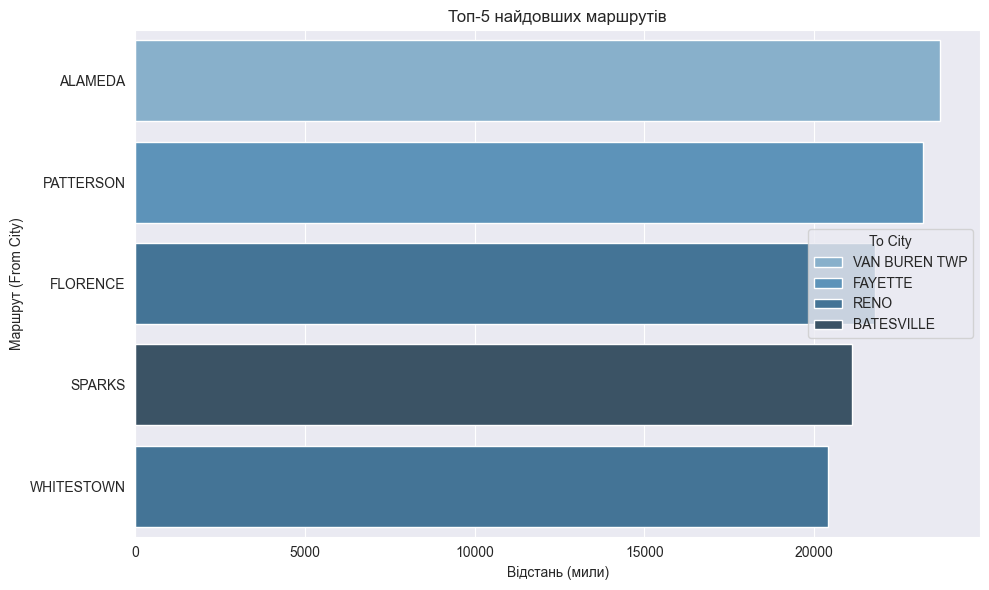

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_5_routes,
    y="From City",
    x="Miles",
    hue="To City",
    palette="Blues_d"
)
plt.title("Топ-5 найдовших маршрутів")
plt.xlabel("Відстань (мили)")
plt.ylabel("Маршрут (From City)")
plt.tight_layout()
plt.show()

In [11]:
from geopy.geocoders import Nominatim
import openrouteservice
from openrouteservice import convert
import folium
import time
from tqdm import tqdm

ORS_API_KEY = "eyJvcmciOiI1YjNjZTM1OTc4NTExMTAwMDFjZjYyNDgiLCJpZCI6IjRkNDI3MjgwYTJjZDRhYzNhMzVlZjM5ZTY5NmM2N2YyIiwiaCI6Im11cm11cjY0In0="

geolocator = Nominatim(user_agent="logistics-map")
ors_client = openrouteservice.Client(key=ORS_API_KEY)
m = folium.Map(location=[39.5, -98.35], zoom_start=4)

for _, row in tqdm(top_5_routes.iterrows(), total=top_5_routes.shape[0]):
    from_city = row["From City"]
    from_state = row["From State"]
    to_city = row["To City"]
    to_state = row["To State"]
    miles = row["Miles"]
    rate = row["Rate"]
    rpm = row["RPM"]

    try:
        from_loc = geolocator.geocode(f"{from_city}, {from_state}", timeout=10)
        to_loc = geolocator.geocode(f"{to_city}, {to_state}", timeout=10)
        time.sleep(1)

        if from_loc and to_loc:
            from_coords = (from_loc.latitude, from_loc.longitude)
            to_coords = (to_loc.latitude, to_loc.longitude)

            coords = [(from_coords[1], from_coords[0]), (to_coords[1], to_coords[0])]
            route = ors_client.directions(coords)
            decoded = convert.decode_polyline(route['routes'][0]['geometry'])

            folium.PolyLine(
                locations=[(lat, lon) for lon, lat in decoded["coordinates"]],
                tooltip=f"{from_city} → {to_city} | {miles} mi | ${rate} | RPM: {rpm:.2f}",
                color="blue"
            ).add_to(m)

            folium.Marker(location=from_coords, popup=f"{from_city}, {from_state}",
                          icon=folium.Icon(color="green")).add_to(m)
            folium.Marker(location=to_coords, popup=f"{to_city}, {to_state}", icon=folium.Icon(color="red")).add_to(m)
        else:
            print("⛔ Геокод не знайдено:", from_city, "→", to_city)

    except Exception as e:
        print(f"❌ Помилка маршруту {from_city} → {to_city}: {e}")

m

/Users/pavlovaskiv/PycharmProjects/LogiTrack/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|██████████| 5/5 [00:25<00:00,  5.13s/it]


In [15]:
top_5_shortest = df.sort_values(by="Miles", ascending=True).head(5)

top_5_shortest[["From City", "To City", "Rate", "Miles", "RPM"]]

,From City,To City,Rate,Miles,RPM
3224,CHICAGO,CHICAGO,200.0,2.0,100.0000
2966,STOCKTON,STOCKTON,1200.0,2.0,600.0000
3437,BALTIMORE,HANOVER,300.0,14.0,21.4286
1366,FONTANA,MIRA LOMA,350.0,16.0,21.8750
1365,FONTANA,MIRA LOMA,350.0,16.0,21.8750


In [18]:
df["Miles"] = pd.to_numeric(df["Miles"], errors="coerce")
df["Rate"] = pd.to_numeric(df["Rate"], errors="coerce")
df["RPM"] = pd.to_numeric(df["RPM"], errors="coerce")

df.head()

missing_miles_count = df["Miles"].isna().sum()
print(f"📌 Є {missing_miles_count} маршрутів з невказаною (відсутньою) довжиною")

📌 Є 21 маршрутів з невказаною (відсутньою) довжиною


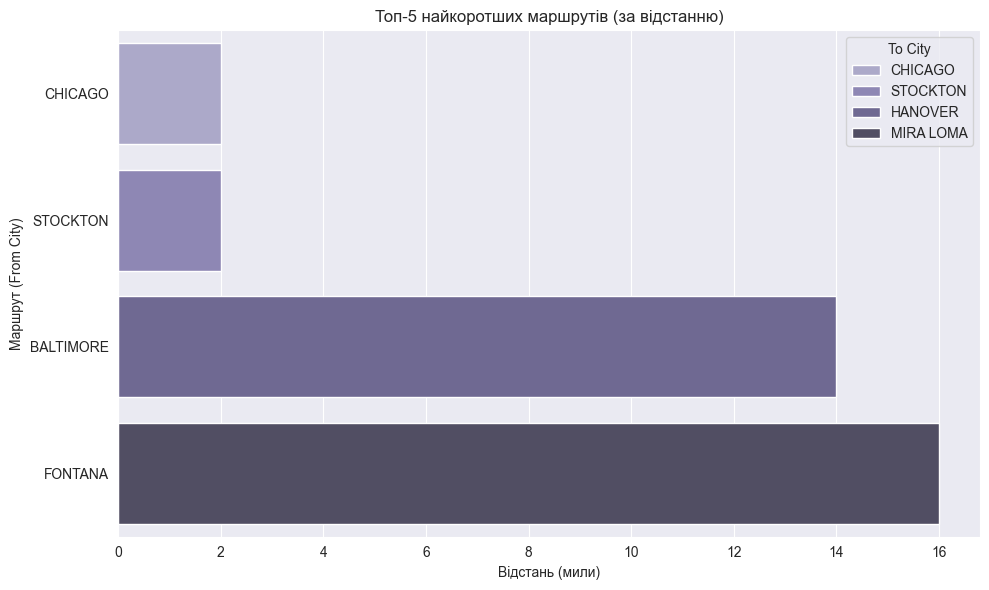

In [19]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_5_shortest,
    y="From City",
    x="Miles",
    hue="To City",
    palette="Purples_d"
)
plt.title("Топ-5 найкоротших маршрутів (за відстанню)")
plt.xlabel("Відстань (мили)")
plt.ylabel("Маршрут (From City)")
plt.tight_layout()
plt.show()

In [20]:
m_shortest = folium.Map(location=[39.5, -98.35], zoom_start=4)

for _, row in tqdm(top_5_shortest.iterrows(), total=top_5_shortest.shape[0]):
    from_city = row["From City"]
    from_state = row["From State"]
    to_city = row["To City"]
    to_state = row["To State"]
    miles = row["Miles"]
    rate = row["Rate"]
    rpm = row["RPM"]

    try:
        from_loc = geolocator.geocode(f"{from_city}, {from_state}", timeout=10)
        to_loc = geolocator.geocode(f"{to_city}, {to_state}", timeout=10)
        time.sleep(1)

        if from_loc and to_loc:
            from_coords = (from_loc.latitude, from_loc.longitude)
            to_coords = (to_loc.latitude, to_loc.longitude)

            coords = [(from_coords[1], from_coords[0]), (to_coords[1], to_coords[0])]
            route = ors_client.directions(coords)
            decoded = convert.decode_polyline(route['routes'][0]['geometry'])

            folium.PolyLine(
                locations=[(lat, lon) for lon, lat in decoded["coordinates"]],
                tooltip=f"{from_city} → {to_city} | {miles} mi | ${rate} | RPM: {rpm:.2f}",
                color="purple"
            ).add_to(m_shortest)

            folium.Marker(location=from_coords, popup=f"{from_city}, {from_state}",
                          icon=folium.Icon(color="green")).add_to(m_shortest)
            folium.Marker(location=to_coords, popup=f"{to_city}, {to_state}",
                          icon=folium.Icon(color="red")).add_to(m_shortest)
        else:
            print("Пропущено (немає координат):", from_city, "→", to_city)

    except Exception as e:
        print("Помилка маршруту", from_city, "→", to_city, ":", e)

# Вивід карти
m_shortest

100%|██████████| 5/5 [00:12<00:00,  2.44s/it]
